In [1]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import aa598.hw1_helper as hw1_helper

from matplotlib import rc
# rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False) # set to False if latex is not set up on your computer

## Visualize data

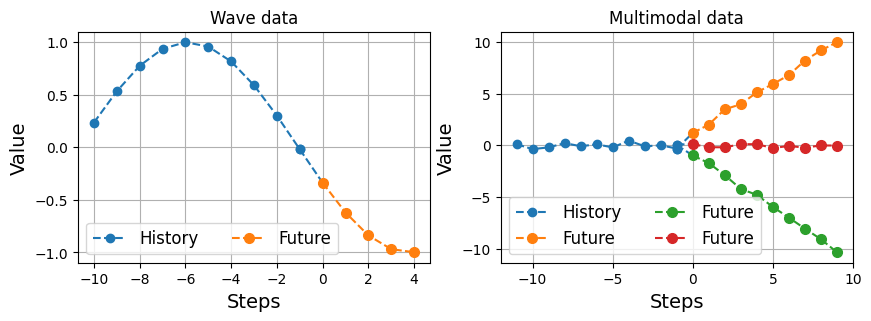

In [2]:
with open("data/hw1/wave_data_train.pickle", 'rb') as handle:
    wave_data = pickle.load(handle)
history = wave_data["history"]
future = wave_data["future"]

index = 1
history_length = history.shape[-1]
future_length = future.shape[-1]
ts_history = np.arange(-history_length,0)
ts_future = np.arange(future_length)

plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.plot(ts_history, history[index], marker='o', linestyle='--', label="History")
plt.plot([-1,0], [history[index][-1], future[index][0]], marker='o', linestyle='--', color="C0")
plt.plot(ts_future, future[index], markersize=7, marker='o', linestyle='--', label="Future")

plt.xlabel('Steps', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12, ncols=2)
plt.title("Wave data")
plt.grid(True)
#plt.show()



with open("data/hw1/multimodal_data_test.pickle", 'rb') as handle:
    wave_data = pickle.load(handle)
history = wave_data["history"]
future = wave_data["future"]


index = 1
history_length = history.shape[-1]
future_length = future.shape[-1]
ts_history = np.arange(-history_length,0)
ts_future = np.arange(future_length)

plt.subplot(1,2,2)
plt.plot(ts_history, history[index], marker='o', linestyle='--', label="History")
for i in range(3):
    plt.plot([-1,0], [history[i*100 + index][-1], future[i*100 + index][0]], marker='o', linestyle='--', color="C0")
    plt.plot(ts_future, future[i*100 + index], markersize=7, marker='o', linestyle='--', label="Future")

plt.xlabel('Steps', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12, ncols=2)
plt.title("Multimodal data")
plt.grid(True)
plt.show()


## Regression with sinusoidal trajectories

In this problem, you will learn a regular MLP to regress on sinusoidal data

In [3]:
# feel free to poke around the data
train_data = hw1_helper.TrajectoryData("data/hw1/wave_data_train")
test_data = hw1_helper.TrajectoryData("data/hw1/wave_data_test")

history_length = 10
future_length = 5
input_size = 1
output_size = 1

print("Train set has %i examples"%len(train_data))
print("Test set has %i examples"%len(test_data))

Train set has 10000 examples
Test set has 500 examples


### Simple MLP predictor

In [4]:
# Define a simple MLP model
class MLP(torch.nn.Module):
    def __init__(self, history_length, future_length, hidden_size=32):
        super(MLP, self).__init__()
        
        # TODO: construct MLP network
        self.l1 = torch.nn.Linear(history_length,hidden_size) # specify layer 1
        self.relu = torch.nn.ReLU() # defines a generic ReLU activation function, very simple
        self.l2 = torch.nn.Linear(hidden_size, hidden_size) # specify layer 2
        self.l3 = torch.nn.Linear(hidden_size,future_length) # specify layer 3, the end of the NN
        #############################

    def forward(self, x):

        # Taken from a previous class' homework in which a NN classifier was trained on the iris dataset.

        out = self.l1(x)  #this specifies the first layer to act on x 
        out = self.relu(out)  #specifies a ReLU activation on the first layer 
        out = self.l2(out)  # specifies a second layer transformation on first layer activations 
        out = self.relu(out)  # specifies a ReLU activation on second layer 
        out = self.l3(out)  # specifies a third layer transformation

        return out

        # return self.model(x)


In [5]:
hidden_size = 8
history_length = 10
future_length = 5

model = MLP(history_length, future_length, hidden_size)

learning_rate = 0.001
num_epochs = 30
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [6]:
model, optimizer = hw1_helper.train(model, optimizer, train_dataloader, criterion, num_epochs)


Epoch [1/30], Step [0/313], Loss: 0.6196
Epoch [1/30], Step [20/313], Loss: 0.4851
Epoch [1/30], Step [40/313], Loss: 0.4979
Epoch [1/30], Step [60/313], Loss: 0.4646
Epoch [1/30], Step [80/313], Loss: 0.4891
Epoch [1/30], Step [100/313], Loss: 0.4219
Epoch [1/30], Step [120/313], Loss: 0.2832
Epoch [1/30], Step [140/313], Loss: 0.4092
Epoch [1/30], Step [160/313], Loss: 0.2707
Epoch [1/30], Step [180/313], Loss: 0.2908
Epoch [1/30], Step [200/313], Loss: 0.1926
Epoch [1/30], Step [220/313], Loss: 0.1441
Epoch [1/30], Step [240/313], Loss: 0.1468
Epoch [1/30], Step [260/313], Loss: 0.1068
Epoch [1/30], Step [280/313], Loss: 0.1094
Epoch [1/30], Step [300/313], Loss: 0.1443
Epoch 1 completed with average loss: 0.2968
Epoch [2/30], Step [0/313], Loss: 0.0933
Epoch [2/30], Step [20/313], Loss: 0.0539
Epoch [2/30], Step [40/313], Loss: 0.0634
Epoch [2/30], Step [60/313], Loss: 0.0645
Epoch [2/30], Step [80/313], Loss: 0.0661
Epoch [2/30], Step [100/313], Loss: 0.0368
Epoch [2/30], Step [12

In [7]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history)         # Forward pass
    loss = criterion(prediction, future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# Visualize prediction on test data
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_data)-1, step=1, description='Index:')
xlims = [-11, 5]
ylims = [-2,2]
interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))

# Test Loss: 0.0009

Test Loss: 0.0004


interactive(children=(IntSlider(value=0, description='Index:', max=499), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

### Simple LSTM predictor

In [8]:
    
class LSTM(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        # HINT: Use Pytorch built-in functions for LSTM and Linear layers.
        # HINT: batch dimension is dim=0
        
        # TODO: Define encoder LSTM.
        self.encoder = torch.nn.LSTM(input_dim,hidden_dim,batch_first=True)
        ############################
        
        # TODO: Define decoder LSTM
        self.decoder = torch.nn.LSTM(output_dim,hidden_dim,batch_first=True)
        ############################

        
        #TODO: Define linear project from hidden_dim to output_dim
        self.projection = torch.nn.Linear(hidden_dim,output_dim)
        ############################

        
        


    def forward(self, x, t_max, y=None, prob=1.):
        """
        Forward pass of the LSTM model.
        x: The input sequence [batch_size, seq_len, input_dim]
        t_max: maximum time steps to unroll
        y: The target sequence for teacher forcing (optional, used if teacher forcing is applied) [batch_size, t_max, output_dim]
        prob: Probability to apply teacher forcing (0 to 1). 1 means 100% teacher forcing, 
        """
        
        # making sure x and y is the appropriate size.
        if len(x.shape) == 2:
            x = x.unsqueeze(-1)
        if y is not None and len(y.shape) == 2:
            y = y.unsqueeze(-1)
        
        
        ys = [] # collect outputs
        # TODO: Run input through encoder to get initial hidden state for decoder

        encoder_output, (h_n, c_n) = self.encoder(x)

        ############################

        
        # TODO: initial state for decoder is last input state
        hidden_state = h_n
        cell_state = c_n

        ############################

        batch_size = x.size(0)
        decoder_input = torch.zeros(batch_size,1,self.output_dim).to(x.device)

        # TODO: unroll decoder 
        for t in range(t_max):
            decoder_output, (hidden_state, cell_state) = self.decoder(decoder_input, (hidden_state, cell_state))
            output = self.projection(decoder_output)
            ys.append(output)


        # TODO: if eval or no teacher forcing, use prediction from previous step
            if self.training and y is not None and torch.rand(1).item() < prob:
                decoder_input = y[:, t].unsqueeze(1)
            else:
                decoder_input = output
        # TODO: if train and using teacher forcing, use prob to determine whether to use ground truth or previous prediction
        
        ############################

        ys = torch.cat(ys, dim=1)
        return ys # [batch_size, ts_max, output_dim]

In [9]:
hidden_size = 4
future_length = 5
input_size = 1
output_size = 1

model = LSTM(input_size, output_size, hidden_size)

learning_rate = 0.001
num_epochs = 10
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
prob = 0.

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()


def prob_schedule(i):
    return 1 - jax.nn.sigmoid(20 * (i - 0.5)).item()



In [10]:
# we use a slightly different training loop to account for teacher forcing
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    prob = prob_schedule((epoch + 1)/num_epochs)
    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()        # Zero the gradients
        output = model(data, future_length, target, prob)         # Forward pass
        output = output.squeeze(-1)
        #print(f'Output shape: {output.shape}, Target shape: {target.shape}')
        #target = target.unsqueeze(-1)
        
        loss = criterion(output, target)  # Compute loss
        loss.backward()              # Backpropagation
        optimizer.step()             # Update weights

        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f}')

print("Training finished!")


Epoch [1/10], Step [0/313], Loss: 0.4382
Epoch [1/10], Step [100/313], Loss: 0.3422
Epoch [1/10], Step [200/313], Loss: 0.2054
Epoch [1/10], Step [300/313], Loss: 0.1181
Epoch 1 completed with average loss: 0.2734
Epoch [2/10], Step [0/313], Loss: 0.1218
Epoch [2/10], Step [100/313], Loss: 0.0717
Epoch [2/10], Step [200/313], Loss: 0.0482
Epoch [2/10], Step [300/313], Loss: 0.0281
Epoch 2 completed with average loss: 0.0612
Epoch [3/10], Step [0/313], Loss: 0.0304
Epoch [3/10], Step [100/313], Loss: 0.0207
Epoch [3/10], Step [200/313], Loss: 0.0196
Epoch [3/10], Step [300/313], Loss: 0.0105
Epoch 3 completed with average loss: 0.0216
Epoch [4/10], Step [0/313], Loss: 0.0175
Epoch [4/10], Step [100/313], Loss: 0.0096
Epoch [4/10], Step [200/313], Loss: 0.0109
Epoch [4/10], Step [300/313], Loss: 0.0110
Epoch 4 completed with average loss: 0.0108
Epoch [5/10], Step [0/313], Loss: 0.0067
Epoch [5/10], Step [100/313], Loss: 0.0050
Epoch [5/10], Step [200/313], Loss: 0.0426
Epoch [5/10], Ste

In [15]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history, future_length)         # Forward pass
    prediction = prediction.squeeze(-1)
    #print(f'Prediction shape: {prediction.shape}, Future shape: {future.shape}')
    #future = future.unsqueeze(-1)
    loss = criterion(prediction, future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# try with different prediction horizons
prediction_horizon = 500
prediction = model(history, prediction_horizon)
prediction = prediction.squeeze(-1)


# Visualize prediction on test data
test_dataloader = list(DataLoader(test_data, batch_size=1, shuffle=False))
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_dataloader)-1, step=1, description='Index:')
xlims = [-11, prediction_horizon + 2]
ylims = [-5,5]
interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



Test Loss: 0.0109


interactive(children=(IntSlider(value=0, description='Index:', max=499), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

## Regression on multimodal data

Now we repeat the same steps but with data where the future has multimodal outcome. 

In [16]:
# load multimodal data
train_data = hw1_helper.TrajectoryData("data/hw1/multimodal_data_train")
test_data = hw1_helper.TrajectoryData("data/hw1/multimodal_data_test")

history_length = 11
future_length = 10
input_size = 1
output_size = 1

print("Train set has %i examples"%len(train_data))
print("Test set has %i examples"%len(test_data))

Train set has 15000 examples
Test set has 300 examples


### Simple MLP predictor (multimodal data)

In [17]:

hidden_size = 32
# You should be able to use your MLP class
model = MLP(history_length, future_length, hidden_size)

learning_rate = 0.001
num_epochs = 10
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

In [18]:
model, optimizer = hw1_helper.train(model, optimizer, train_dataloader, criterion, num_epochs)

Epoch [1/10], Step [0/469], Loss: 27.6636
Epoch [1/10], Step [20/469], Loss: 26.4821
Epoch [1/10], Step [40/469], Loss: 25.2927
Epoch [1/10], Step [60/469], Loss: 25.3506
Epoch [1/10], Step [80/469], Loss: 31.3128
Epoch [1/10], Step [100/469], Loss: 22.8688
Epoch [1/10], Step [120/469], Loss: 24.3351
Epoch [1/10], Step [140/469], Loss: 30.2232
Epoch [1/10], Step [160/469], Loss: 27.8294
Epoch [1/10], Step [180/469], Loss: 30.3035
Epoch [1/10], Step [200/469], Loss: 25.3002
Epoch [1/10], Step [220/469], Loss: 26.5847
Epoch [1/10], Step [240/469], Loss: 22.9095
Epoch [1/10], Step [260/469], Loss: 26.2280
Epoch [1/10], Step [280/469], Loss: 18.1121
Epoch [1/10], Step [300/469], Loss: 26.3039
Epoch [1/10], Step [320/469], Loss: 28.7227
Epoch [1/10], Step [340/469], Loss: 28.6366
Epoch [1/10], Step [360/469], Loss: 30.1196
Epoch [1/10], Step [380/469], Loss: 22.9758
Epoch [1/10], Step [400/469], Loss: 27.7219
Epoch [1/10], Step [420/469], Loss: 30.0946
Epoch [1/10], Step [440/469], Loss: 23

In [19]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history)         # Forward pass
    loss = criterion(prediction, future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# Visualize prediction on test data
test_dataloader = list(DataLoader(test_data, batch_size=1, shuffle=False))
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_dataloader)-1, step=1, description='Index:')
xlims = [-11, 10]
ylims = [-12, 12]
interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



Test Loss: 26.0220


interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

### Simple LSTM predictor (multimodal data)

In [20]:
hidden_size = 4
# You should be able to use your LSTM class
model = LSTM(input_size, output_size, hidden_size)

learning_rate = 0.001
num_epochs = 10
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()


In [21]:
# we use a slightly different training loop to account for teacher forcing
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()        # Zero the gradients
        output = model(data, future_length, target, prob)         # Forward pass
        output = output.squeeze(-1)
        loss = criterion(output, target)  # Compute loss
        loss.backward()              # Backpropagation
        optimizer.step()             # Update weights

        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f}')

print("Training finished!")


Epoch [1/10], Step [0/469], Loss: 25.7852
Epoch [1/10], Step [100/469], Loss: 25.1653
Epoch [1/10], Step [200/469], Loss: 31.2203
Epoch [1/10], Step [300/469], Loss: 24.0368
Epoch [1/10], Step [400/469], Loss: 28.9959
Epoch 1 completed with average loss: 25.7246
Epoch [2/10], Step [0/469], Loss: 30.3875
Epoch [2/10], Step [100/469], Loss: 26.5767
Epoch [2/10], Step [200/469], Loss: 26.6951
Epoch [2/10], Step [300/469], Loss: 23.8867
Epoch [2/10], Step [400/469], Loss: 26.6829
Epoch 2 completed with average loss: 25.7041
Epoch [3/10], Step [0/469], Loss: 23.0220
Epoch [3/10], Step [100/469], Loss: 33.7290
Epoch [3/10], Step [200/469], Loss: 27.5418
Epoch [3/10], Step [300/469], Loss: 31.2523
Epoch [3/10], Step [400/469], Loss: 24.0113
Epoch 3 completed with average loss: 25.7061
Epoch [4/10], Step [0/469], Loss: 26.4593
Epoch [4/10], Step [100/469], Loss: 30.0332
Epoch [4/10], Step [200/469], Loss: 19.2911
Epoch [4/10], Step [300/469], Loss: 22.7750
Epoch [4/10], Step [400/469], Loss: 2

In [22]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history, future_length)         # Forward pass
    prediction = prediction.squeeze(-1)
    loss = criterion(prediction, future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# TODO: try with different prediction horizons
prediction_horizon = future_length
prediction = model(history, prediction_horizon)
prediction = prediction.squeeze(-1)

# Visualize prediction on test data
test_dataloader = list(DataLoader(test_data, batch_size=1, shuffle=False))
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_dataloader)-1, step=1, description='Index:')

xlims = [-11, prediction_horizon + 2]
ylims = [-12, 12]

interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



Test Loss: 25.7164


interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

## Consider CVAEs

First, define the encoder and decoder. We will consider some simple MLP encoders. Generally, for trajectory data, it's typically more common to use RNNs or transformers, but since we are considering a small toy problem, we just consider MLP for now since it's simpler.


In [23]:

# some simple MLP encoders. For trajectory data, it's typically more common to use RNNs or transformers
class MLPEncoder(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=32):
        super(MLPEncoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.l1 = torch.nn.Linear(input_dim,hidden_dim) # specify layer 1
        self.relu = torch.nn.ReLU() # defines a generic ReLU activation function, very simple
        self.l2 = torch.nn.Linear(hidden_dim, hidden_dim) # specify layer 2
        self.l3 = torch.nn.Linear(hidden_dim,output_dim) # specify layer 3, the end of the NN
        #############################

    def forward(self, x):

        # Taken from a previous class' homework in which a NN classifier was trained on the iris dataset.

        out = self.l1(x)  #this specifies the first layer to act on x 
        out = self.relu(out)  #specifies a ReLU activation on the first layer 
        out = self.l2(out)  # specifies a second layer transformation on first layer activations 
        out = self.relu(out)  # specifies a ReLU activation on second layer 
        out = self.l3(out)  # specifies a third layer transformation

        return out
    #     # TODO: Construct an MLP encoder
    #     self.model = None   
    #     ############################


    # def forward(self, x):
    #     return self.model(x)
    
    
class MLPDecoder(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=32):
        super(MLPDecoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.l1 = torch.nn.Linear(input_dim, hidden_dim) # specify layer 1
        self.relu = torch.nn.ReLU() # defines a generic ReLU activation function, very simple
        self.l2 = torch.nn.Linear(hidden_dim, hidden_dim) # specify layer 2
        self.l3 = torch.nn.Linear(hidden_dim, output_dim) # specify layer 3, the end of the NN
        #############################

    def forward(self, x):

        # Taken from a previous class' homework in which a NN classifier was trained on the iris dataset.

        out = self.l1(x)  #this specifies the first layer to act on x 
        out = self.relu(out)  #specifies a ReLU activation on the first layer 
        out = self.l2(out)  # specifies a second layer transformation on first layer activations 
        out = self.relu(out)  # specifies a ReLU activation on second layer 
        out = self.l3(out)  # specifies a third layer transformation

        return out
    #     # TODO: Construct an MLP encoder
    #     self.model = None
    #     ############################


    # def forward(self, x):
    #     return self.model(x)


# Some helper functions
def repeat_n(ten, n):
    return torch.stack([ten] * n, dim=0)

def beta_schedule(i):
    return jax.nn.sigmoid(20 * (i - 0.5)).item()


In [24]:
train_data = hw1_helper.TrajectoryData("data/hw1/multimodal_data_train")
test_data = hw1_helper.TrajectoryData("data/hw1/multimodal_data_test")

history_length = 11
future_length = 10
input_size = 1
output_size = 1

print("Train set has %i examples"%len(train_data))
print("Test set has %i examples"%len(test_data))

Train set has 15000 examples
Test set has 300 examples


### Continuous CVAE

In [28]:
class ContinuousCVAE(torch.nn.Module):
    def __init__(self, latent_dim, importance, decoder, prior):
        '''
        latent_dim: dimension of the continuous latent space
        importance: network to encode the importance weight
        decoder: network to decode the output
        prior: network to encode the prior        
        '''
        
        super(ContinuousCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.importance = importance
        self.decoder = decoder
        self.prior = prior
        
        # TODO: Linear layers to project encoder/decoder to mean and logvar
        self.mean_projection_encoder = torch.nn.Linear(latent_dim, latent_dim)
        self.logvar_projection_encoder = torch.nn.Linear(latent_dim, latent_dim)
        self.mean_projection_decoder = torch.nn.Linear(latent_dim, latent_dim)
        self.logvar_projection_decoder = torch.nn.Linear(latent_dim, latent_dim)
        ############################

        
    def encode_importance(self, x, y):
        '''Computes mean and log(covariance) of q(z|x,y), assumes normal distribution'''
        
        # TODO: compute z_mu and z_logvar of q(z|x,y)
        z = self.importance(torch.cat([x,y], dim=-1))

        z_mu = self.mean_projection_encoder(z)
        z_logvar = self.logvar_projection_encoder(z)
        ############################
        
        return z_mu, z_logvar
    
    
    def encode_prior(self, x):
        '''Computes mean and log(covariance) of p(z|x), assumes normal distribution'''
        
        # TODO: compute z_mu and z_logvar of p(z|x)
        z = self.prior(x)
        z_mu = self.mean_projection_encoder(z)
        z_logvar = self.logvar_projection_encoder(z)
        ############################
        
        return z_mu, z_logvar
    
    
    def reparameterize(self, mu, logvar, n=1):
        '''samples from a normal distributions parameterized by mu and logvar. Uses PyTorch built-in reparameratization trick'''
        
        prob = torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=torch.diag_embed(torch.exp(logvar)))
        
        return prob.rsample((n,))
    
    
    def decode(self, x, z):
        '''Computes mean and log(covariance) of p(y|x,z), assumes normal distribution'''
        
        # TODO: compute y_mu and y_logvar of p(y|x,z)
        y = torch.cat([x,z],dim=-1)
        out = self.decoder(y)

        y_mu = self.mean_projection_decoder(out)
        y_logvar = self.logvar_projection_decoder(out)
        ############################
        
        return y_mu, y_logvar

    
    def forward(self, x, y, n=1):
        '''forward pass of the cvae model'''
        
        #  get p(z|x,(y))
        if self.training:
            z_mu, z_logvar = self.encode_importance(x, y)
        else:
            z_mu, z_logvar = self.encode_prior(x)
        # sample from p(z|x,(y)) n times
        z = self.reparameterize(z_mu, z_logvar, n)
        # get p(y|x,z)
        y_mu, y_logvar  = self.decode(repeat_n(x, n), z)     
           
        return z_mu, z_logvar, y_mu, y_logvar
    

    
    def sample(self, x, num_samples=8, num_latent_samples=8):
        '''samples from p(y|x,z) where z~p(z|x). Need to specify the number z and y samples to draw'''
        
        _, _, y_mu, y_logvar = self.forward(x, None, num_latent_samples)

        return self.reparameterize(y_mu, y_logvar, num_samples)

    
    
    def elbo(self, x, y, z_samples=1, beta=1.):
        '''Compute ELBO for CVAE with continuous latent space. Optional: beta term that weigh kl divergence term'''
        
        q_mu, q_logvar, y_mu, y_logvar = self(x, y, z_samples) # get parameters for q(z|x,y) and p(y|x,z) where z~q(z|x,y)
        p_mu, p_logvar = self.encode_prior(x) # get parameters for p(z|x)
        
        # construct the distributions
        y_prob = torch.distributions.MultivariateNormal(loc=y_mu, covariance_matrix=torch.diag_embed(torch.exp(y_logvar)))  # p(y|x, z)
        q = torch.distributions.MultivariateNormal(loc=q_mu, covariance_matrix=torch.diag_embed(torch.exp(q_logvar)))  # q(z|x,y)
        p = torch.distributions.MultivariateNormal(loc=p_mu, covariance_matrix=torch.diag_embed(torch.exp(p_logvar)))  # p(z|x)
        
        loglikelihood = -y_prob.log_prob(repeat_n(y, z_samples)).mean() # log likelihood of data 
        kl_div = torch.distributions.kl.kl_divergence(q, p).mean()  # q_z * (log(q_z) - log(p_z))
        
        return loglikelihood + beta * kl_div
        


      

In [29]:
# continuous cvae
# network parameters
latent_dim = 1 # size of latent space
history_length = 11
future_length = 10
hidden_dim = 8
enc_dim = 8
dec_dim = 8

encoder = MLPEncoder(history_length + future_length, hidden_dim, enc_dim)
prior = MLPEncoder(history_length, hidden_dim, enc_dim)
decoder = MLPDecoder(latent_dim+history_length, future_length, dec_dim)

cvae = ContinuousCVAE(latent_dim, encoder, decoder, prior)

num_epochs = 10
learning_rate = 1E-3
optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate)


batch_size = 8
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)



In [30]:
# train model
z_samples = 16
cvae.train()

for epoch in range(num_epochs):
    running_loss = 0
    beta = beta_schedule((epoch + 1)/ num_epochs) # we slowly increase the weighting on the KL divergence, following https://openreview.net/forum?id=Sy2fzU9gl
    for batch_idx, (history, future) in enumerate(train_dataloader):
        q_mu, q_logvar, y_mu, y_logvar = cvae(history, future)
        p_mu, p_logvar = cvae.encode_prior(history)
        optimizer.zero_grad()
        loss = cvae.elbo(history, future, z_samples, beta)
        loss.backward()
        running_loss += loss.detach().cpu().numpy()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'======= Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f} =======')

print("Training finished!")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x8 and 1x1)

In [31]:
# Visualize prediction on test data

cvae.eval()

num_samples = 8
num_latent_samples = 8

test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = cvae.sample(history, num_samples, num_latent_samples)
    
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_data)-1, step=1, description='Index:')
xlims = [-12, 10]
ylims = [-12, 12]
interact(hw1_helper.plot_data_generative, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))


RuntimeError: mat1 and mat2 shapes cannot be multiplied (300x8 and 1x1)

IndexError: too many indices for tensor of dimension 2

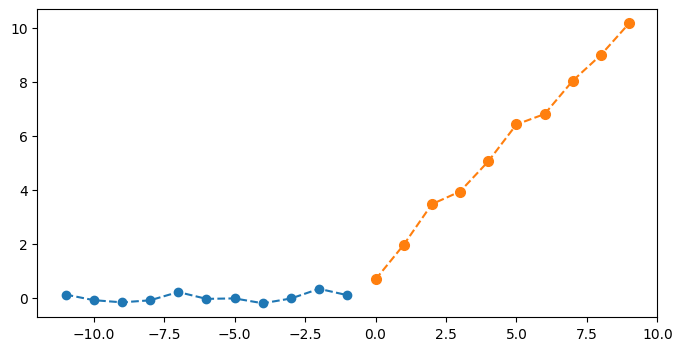

In [32]:
index = 5 # choose an index you want to plot
hw1_helper.plot_data_generative(history=history, future=future, prediction=prediction, index=index, xlims=xlims, ylims=ylims)


### Discrete CVAE

In [33]:
class DiscreteCVAE(torch.nn.Module):
    def __init__(self, latent_dim, importance, decoder, prior, num_categories):
        '''
        latent_dim: dimension of the continuous latent space
        importance: network to encode the importance weight
        decoder: network to decode the output
        prior: network to encode the prior  
        num_categories: number of categories per latent dimension 
        '''
        
        super(DiscreteCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.importance = importance
        self.decoder = decoder
        self.prior = prior
        
        self.logits_projection_encoder = torch.nn.Linear(importance.output_dim, latent_dim * num_categories)
        self.mean_projection_decoder = torch.nn.Linear(decoder.output_dim, decoder.output_dim)
        self.logvar_projection_decoder = torch.nn.Linear(decoder.output_dim, decoder.output_dim)
        self.num_categories = num_categories
        
        # Gumbel-softmax reparameterization
        self.gumbel_temperature = 0.1
        
    def encode_importance(self, x, y):
        '''Computes logits of q(z|x,y), assumes one-hot categorical'''
        xy = torch.cat([x, y], dim=-1)
        h = self.importance(xy)
        z_logits = self.logits_projection_encoder(h).reshape(-1, self.latent_dim, self.num_categories)      
        return z_logits
    
    
    def encode_prior(self, x):
        '''Computes logits of p(z|x), assumes one-hot categorical'''
        h = self.prior(x)
        z_logits = self.logits_projection_encoder(h).reshape(-1, self.latent_dim, self.num_categories)
        
        return z_logits


    def reparameterize(self, logits):
        '''Sample latent variables using one-hot categorical distributions. Uses gumbel-softmax trick. Pytorch has a bulit-in function for this.'''
        
        return F.gumbel_softmax(logits, tau=self.gumbel_temperature, hard=True) 
        
        
    def decode(self, x, z):
        '''Computes mean and log(covariance) of p(y|x,z), assumes normal distribution'''
        xz = torch.cat([x, z], dim=-1)
        g = self.decoder(xz)
        y_mu = self.mean_projection_decoder(g)
        y_logvar = torch.clip(self.logvar_projection_decoder(g), min=-10, max=1)
        
        return y_mu, y_logvar


    def forward(self, x, y, n=1):
        '''forward pass of the cvae model'''
        #  get p(z|x,(y)) and samples from it n times
        if self.training:
            logits = self.encode_importance(x, y) # [bs, latent_dim, num_categories]
            z = self.reparameterize(repeat_n(logits, n)) # [n, bs, latent_dim, num_categories]
        else:
            logits = self.encode_prior(x) # [bs, latent_dim, num_categories]
            z = torch.distributions.OneHotCategorical(logits=logits).sample((n,)) # [n, bs, latent_dim, num_categories]
        z_flatten = z.view(n, -1, self.latent_dim * self.num_categories)  # reshapes to [n, bs, latent_dim * num_categories]
        # get p(y|x,z)
        y_mu, y_logvar  = self.decode(repeat_n(x, n), z_flatten) 

        return logits, y_mu, y_logvar
    
    
    def sample(self, x, num_samples=8, num_latent_samples=8):
        '''samples from p(y|x,z) where z~p(z|x). Need to specify the number z and y samples to draw'''
        _, y_mu, y_logvar = self.forward(x, None, num_latent_samples)

        return  torch.distributions.MultivariateNormal(loc=y_mu, covariance_matrix=torch.diag_embed(torch.exp(y_logvar))).rsample((num_samples,))
        
        
    def elbo(self, x, y, z_samples=1, beta=1.):
        '''Compute ELBO for CVAE with discrete latent space. Optional: beta term that weigh kl divergence term'''

        logits, y_mu, y_logvar = self.forward(x, y, z_samples)
        prior_logits = cvae.encode_prior(x)
        
        y_prob = torch.distributions.MultivariateNormal(loc=y_mu, covariance_matrix=torch.diag_embed(torch.exp(y_logvar)))  # p(y|x, z)
        
        q_z = F.softmax(logits, dim=-1)  # q(z|x,y)
        log_p_z = F.log_softmax(prior_logits, dim=-1)  # log(p(z|x))
        
        loglikelihood = -y_prob.log_prob(repeat_n(y, z_samples)).mean()
        kl_div = torch.nn.KLDivLoss(reduction="batchmean")(log_p_z, q_z)
        
        return loglikelihood + beta * kl_div
      

        


In [38]:
# discrete CVAE

history_length = 11
future_length = 10
hidden_dim = 12
enc_dim = 8
dec_dim = 8

latent_dim = 2
num_categories = 3

encoder = MLPEncoder(history_length + future_length, hidden_dim, enc_dim)
prior = MLPEncoder(history_length, hidden_dim, enc_dim)
decoder = MLPDecoder(latent_dim * num_categories + history_length, future_length, dec_dim)

cvae = DiscreteCVAE(latent_dim, encoder, decoder, prior, num_categories)

learning_rate = 1E-3
optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate, weight_decay=1E-2)

batch_size = 8
num_epochs = 20
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [40]:
# train model
cvae.train()
num_latent_samples = 8
for epoch in range(num_epochs):
    running_loss = 0
    for batch_idx, (history, future) in enumerate(train_dataloader):
        beta = beta_schedule((epoch+1) / num_epochs) # we slowly increase the weighting on the KL divergence, following https://openreview.net/forum?id=Sy2fzU9gl
        optimizer.zero_grad()
        loss = cvae.elbo(history, future, num_latent_samples, beta)
        loss.backward()
        running_loss += loss.detach().cpu().numpy()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'======= Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f} =======')

print("Training finished!")

Epoch [1/20], Step [0/1875], Loss: -1.9141
Epoch [1/20], Step [100/1875], Loss: -0.8113
Epoch [1/20], Step [200/1875], Loss: -3.0844
Epoch [1/20], Step [300/1875], Loss: -1.3748
Epoch [1/20], Step [400/1875], Loss: -1.5828
Epoch [1/20], Step [500/1875], Loss: -1.1875
Epoch [1/20], Step [600/1875], Loss: -1.9963
Epoch [1/20], Step [700/1875], Loss: -1.1091
Epoch [1/20], Step [800/1875], Loss: -2.6071
Epoch [1/20], Step [900/1875], Loss: -2.3089
Epoch [1/20], Step [1000/1875], Loss: -0.6544
Epoch [1/20], Step [1100/1875], Loss: -1.7313
Epoch [1/20], Step [1200/1875], Loss: -1.7861
Epoch [1/20], Step [1300/1875], Loss: -0.0143
Epoch [1/20], Step [1400/1875], Loss: -1.1593
Epoch [1/20], Step [1500/1875], Loss: -2.2168
Epoch [1/20], Step [1600/1875], Loss: -1.4860
Epoch [1/20], Step [1700/1875], Loss: -0.7357
Epoch [1/20], Step [1800/1875], Loss: -2.3004
======= Epoch 1 completed with average loss: -1.6826 =======
Epoch [2/20], Step [0/1875], Loss: -0.5571
Epoch [2/20], Step [100/1875], Los

In [36]:
# Visualize prediction on test data

cvae.eval()
num_latent_samples = 32
num_samples = 1

test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = cvae.sample(history, num_samples, num_latent_samples)
    
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_data)-1, step=1, description='Index:')
xlims = [-12, 10]
ylims = [-12, 12]
interact(hw1_helper.plot_data_generative, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))


interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_generative(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

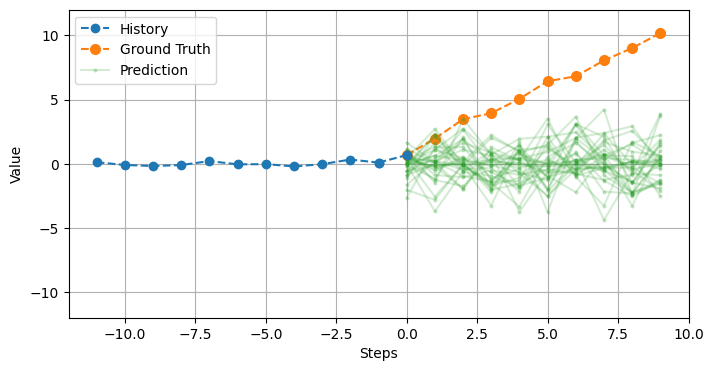

In [37]:
index = 123 # choose an index you want to plot
hw1_helper.plot_data_generative(history=history, future=future, prediction=prediction, index=index, xlims=xlims, ylims=ylims)
